In [1]:
import time
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
offset1 = 0.25
offset2 = 1

def grav_wave(t):
    
    A = 1
    B = np.random.rand(1)
    C = np.random.rand(1)
    D = 100 + np.random.rand(1)
    E = np.random.rand(1)

    y1 = (A * np.exp(-(np.square((t-0.00)-B))/(np.square(C))) * np.sin(D*t + E))
    y2 = (A * np.exp(-(np.square((t-offset1)-B))/(np.square(C))) * np.sin(D*t + E))
    y3 = (A * np.exp(-(np.square((t-offset2)-B))/(np.square(C))) * np.sin(D*t + E))
    
    # noise = np.random.uniform(-0.5, 0.5, size=y1.shape)
    snr_inverse = 2
    noise = snr_inverse * np.random.normal(0,1,8192)
    noise = noise[:ratio]
    
    # Normalize data so that variance is 1 (when we don't know the SNR of signal)
    
    n1 = y1 + noise
    n2 = y2 + noise
    n3 = y3 + noise
    
    return (n1, n2, n3, y1, y2, y3)


In [3]:
def build_model(layers):
    # here layers is a list with 4 elements
    
    model = Sequential()
    
    model.add(LSTM(
        input_dim = layers[0],
        output_dim = layers[1],
        return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[3],
        return_sequences = False))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        output_dim = layers[4]))
    model.add(Activation("linear"))
    
    model.compile(loss="mse", optimizer="rmsprop")
    
    # try changing whether there is dropout, activation function, loss function, number of layers, in/out of layers
    
    return model

In [4]:
def train(ratio):
    t = np.linspace(-2, 3, 8192)
    t = t[:ratio]

    # Generate Training Data

    x_train_1 = []
    x_train_2 = []
    x_train_3 = []
    y_train = []
    y_train_2 = []
    y_train_3 = []

    for i in range(4500):
        wave = grav_wave(t)
        x_train_1.append(wave[0][:ratio])
        x_train_2.append(wave[1][:ratio])
        x_train_3.append(wave[2][:ratio])
        y_train.append(wave[3][:ratio])

        # for displaying purposes
        if i == 0:
            y_train_2.append(wave[4][:ratio])
            y_train_3.append(wave[5][:ratio])
            
    # Generate Testing Data

    x_test_1 = []
    x_test_2 = []
    x_test_3 = []
    y_test = []

    for i in range(500):
        wave = grav_wave(t)
        x_test_1.append(wave[0][:ratio])
        x_test_2.append(wave[1][:ratio])
        x_test_3.append(wave[2][:ratio])
        y_test.append(wave[3][:ratio])
        
    # Reshape x_train to have a shape of (4500, 8192, 3)
    x_train_1 = np.squeeze(x_train_1)
    x_train_2 = np.squeeze(x_train_2)
    x_train_3 = np.squeeze(x_train_3)

    x_train_1 = np.array(x_train_1)
    x_train_2 = np.array(x_train_2)
    x_train_3 = np.array(x_train_3)

    x_train_1 = np.expand_dims(x_train_1, axis=-1)
    x_train_2 = np.expand_dims(x_train_2, axis=-1)
    x_train_3 = np.expand_dims(x_train_3, axis=-1)

    x_train = np.concatenate((x_train_1, x_train_2, x_train_3), axis=-1)

    # Reshape x_test to have a shape of (500, 8192, 3)
    x_test_1 = np.squeeze(x_test_1)
    x_test_2 = np.squeeze(x_test_2)
    x_test_3 = np.squeeze(x_test_3)

    x_test_1 = np.array(x_test_1)
    x_test_2 = np.array(x_test_2)
    x_test_3 = np.array(x_test_3)

    x_test_1 = np.expand_dims(x_test_1, axis=-1)
    x_test_2 = np.expand_dims(x_test_2, axis=-1)
    x_test_3 = np.expand_dims(x_test_3, axis=-1)

    x_test = np.concatenate((x_test_1, x_test_2, x_test_3), axis=-1)

    # Convert y_train and y_test to NumPy Arrays (from Python Lists)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Train
    
    epochs = 1
    global_start_time = time.time()

    model = build_model([3, 64, 128, 64, ratio])

    model.fit(x_train,
              y_train,
              batch_size=64,
              nb_epoch=epochs,
              validation_split=0)

    predicted = model.predict(x_test)

    print(" ")
    print('Training duration (min) : ', (time.time() - global_start_time)/60)
    
    # Calculate Average MSE
    
    t_two = np.linspace(-2, 3, ratio)
    avg_mse = 0
    count_1 = 0
    count_2 = 0
    for i in range(500):
        avg_mse += np.square(np.sum(y_test[i] - predicted[i]))
        if np.square(np.sum(y_test[i] - predicted[i])) > 100:
            count_2 += 1
        elif np.square(np.sum(y_test[i] - predicted[i])) < 0.1:
            count_1 += 1

    print("Signal Length: " + str(float(ratio) / 8192) +  " sec")
    print("Average MSE: ", avg_mse / 500)
    print("MSE < 0.1: " + str(count_1) + ", MSE > 100: " + str(count_2))
    
    # Display a sample of the results
    
    print("A Sample of the Results:")

    n = 3
    print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
    plt.plot(t_two, x_test[n], "b-", label='Noisy Signal')
    plt.plot(t_two, y_test[n], "y-", label='True Data', linewidth=2.0)
    plt.plot(t_two, predicted[n], "r-", label='Prediction', linewidth=2.0)
    red_patch = mpatches.Patch(color='red', label='Prediction')
    yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
    plt.legend(handles=[red_patch, yellow_patch])
    plt.show()

    n = 4
    print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
    plt.plot(t_two, x_test[n], "b-", label='Noisy Signal')
    plt.plot(t_two, y_test[n], "y-", label='True Data', linewidth=2.0)
    plt.plot(t_two, predicted[n], "r-", label='Prediction', linewidth=2.0)
    red_patch = mpatches.Patch(color='red', label='Prediction')
    yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
    plt.legend(handles=[red_patch, yellow_patch])
    plt.show()

    n = 7
    print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
    plt.plot(t_two, x_test[n], "b-", label='Noisy Signal')
    plt.plot(t_two, y_test[n], "y-", label='True Data', linewidth=2.0)
    plt.plot(t_two, predicted[n], "r-", label='Prediction', linewidth=2.0)
    red_patch = mpatches.Patch(color='red', label='Prediction')
    yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
    plt.legend(handles=[red_patch, yellow_patch])
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=64, return_sequences=True, input_shape=(None, 3))`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=7372)`
/home/arjung2/.local/lib/python2.7/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
4500/4500 [==============================] - 2794s 621ms/step - loss: 0.0337
 
('Training duration (min) : ', 48.912173330783844)
Signal Length: 0.89990234375 sec
('Average MSE: ', 3.0714343588754209)
MSE < 0.1: 410, MSE > 100: 5
A Sample of the Results:
('MSE: ', 0.061983806174672217)


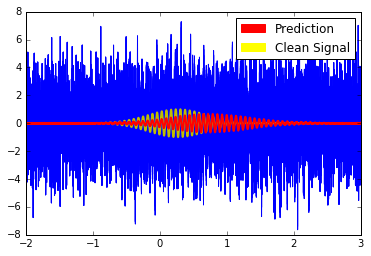

('MSE: ', 0.02989250798339161)


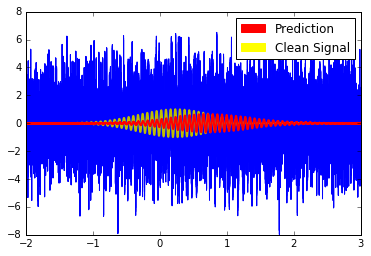

('MSE: ', 0.043920592258596451)


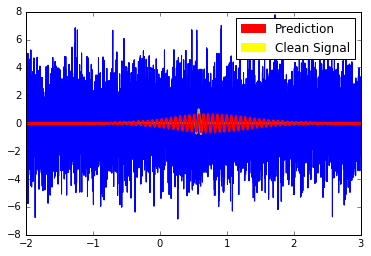

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=5734)`


Epoch 1/1
4500/4500 [==============================] - 2191s 487ms/step - loss: 0.0372
 
('Training duration (min) : ', 38.37023538351059)
Signal Length: 0.699951171875 sec
('Average MSE: ', 13.245139454906527)
MSE < 0.1: 64, MSE > 100: 12
A Sample of the Results:
('MSE: ', 0.45380502175789833)


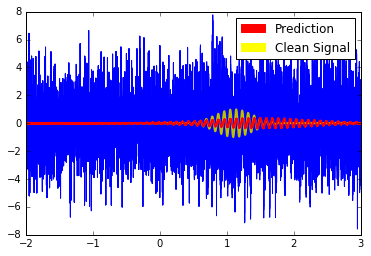

('MSE: ', 1.435111632204658)


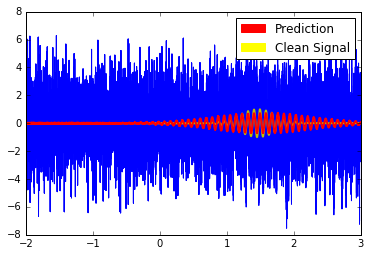

('MSE: ', 4.7013689103348977)


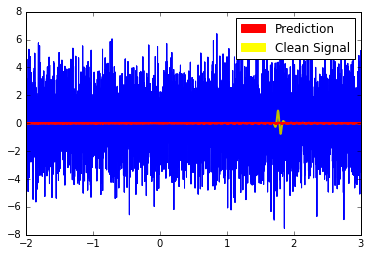

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=4096)`


Epoch 1/1
4500/4500 [==============================] - 1566s 348ms/step - loss: 0.0225
 
('Training duration (min) : ', 27.442880884806314)
Signal Length: 0.5 sec
('Average MSE: ', 26.703715177516365)
MSE < 0.1: 26, MSE > 100: 40
A Sample of the Results:
('MSE: ', 1.2382892602984203)


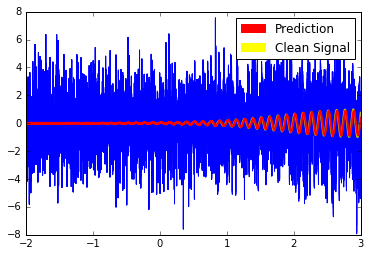

('MSE: ', 91.51365203334251)


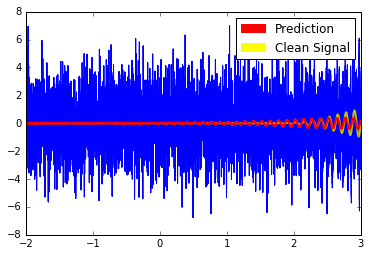

('MSE: ', 24.203275742662782)


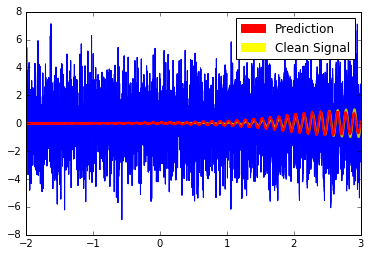

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=2457)`


Epoch 1/1
4500/4500 [==============================] - 947s 210ms/step - loss: 0.0017
 
('Training duration (min) : ', 16.62277316649755)
Signal Length: 0.299926757812 sec
('Average MSE: ', 2.2850728319701097)
MSE < 0.1: 202, MSE > 100: 0
A Sample of the Results:
('MSE: ', 0.037085479131335884)


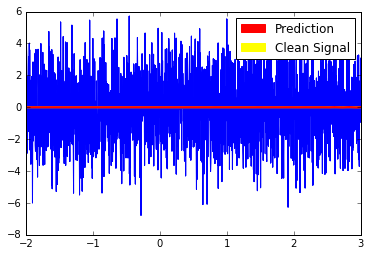

('MSE: ', 0.34568431770226449)


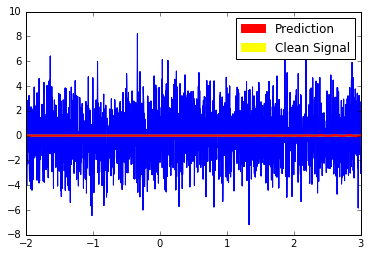

('MSE: ', 0.0752555002383231)


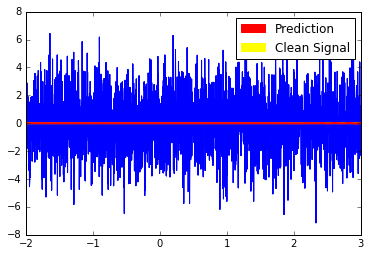

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=819)`


Epoch 1/1
4500/4500 [==============================] - 325s 72ms/step - loss: 2.0263e-05
 
('Training duration (min) : ', 5.753645181655884)
Signal Length: 0.0999755859375 sec
('Average MSE: ', 0.013155437231953676)
MSE < 0.1: 486, MSE > 100: 0
A Sample of the Results:
('MSE: ', 0.0027180904232736486)


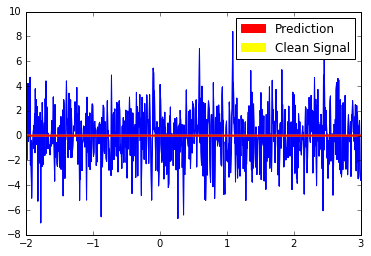

('MSE: ', 0.0031202922497159872)


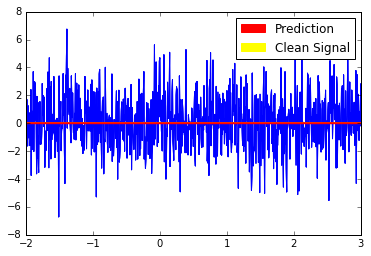

('MSE: ', 0.0078899577266015736)


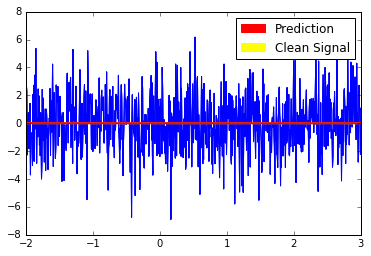

In [5]:
ratio = int(0.9 * 8192)
train(ratio)
print("-"*117*5)
ratio = int(0.7 * 8192)
train(ratio)
print("-"*117*5)
ratio = int(0.5 * 8192)
train(ratio)
print("-"*117*5)
ratio = int(0.3 * 8192)
train(ratio)
print("-"*117*5)
ratio = int(0.1 * 8192)
train(ratio)

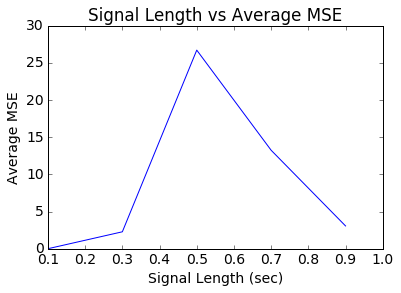

In [13]:
t_three = [0.1, 0.3, 0.5, 0.7, 0.9]
average_mse = [0.013155437231953676, 2.2850728319701097, 26.703715177516365, 13.245139454906527, 3.0714343588754209]
plt.plot(t_three, average_mse)
plt.title("Signal Length vs Average MSE")
plt.xlabel("Signal Length (sec)")
plt.ylabel("Average MSE")
plt.rcParams.update({'font.size': 14})
plt.show()